In [1]:
try:
    import flax.linen as nn
except ModuleNotFoundError:
    %pip install -qq flax
    import flax.linen as nn

from flax.core import unfreeze

from flax.training import train_state

import jax
import jax.numpy as jnp
from jax.config import config

try:
    import optax
except ModuleNotFoundError:
    %pip install -qq optax
    import optax

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

try:
    from probml_utils import latexify, savefig, is_latexify_enabled
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    from probml_utils import latexify, savefig, is_latexify_enabled

from scipy.ndimage import rotate

try:
    import tensorflow.keras.datasets as tfds
except ModuleNotFoundError:
    %pip install -qq tensorflow
    import tensorflow.keras.datasets as tfds

from functools import partial

try:
    from tqdm import tqdm
except ModuleNotFoundError:
    %pip install tqdm
    from tqdm import tqdm

import pandas as pd

In [2]:
config.update("jax_enable_x64", True)

In [3]:
# %env LATEXIFY= 1
# %env FIG_DIR=figures/

In [4]:
latexify(width_scale_factor=2, fig_height=2)

/home/rohit_khoiwal/anaconda3/lib/python3.9/site-packages/probml_utils/plotting.py:26: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")


In [5]:
class LeNet(nn.Module):
    @nn.compact
    def __call__(self, x, deterministic):

        # 1 layer
        x = nn.Conv(features=6, kernel_size=(5, 5), name="conv2d_1")(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2))

        # 2 layer
        x = nn.Conv(features=16, kernel_size=(5, 5), name="conv2d_2")(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2))

        # 3 layer
        x = nn.Conv(features=120, kernel_size=(5, 5), name="conv2d_3")(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2))

        x = x.reshape((x.shape[0], -1))  # flatten
        # 4 fully connected layer
        x = nn.Dense(84, name="Dense_1_84")(x)
        x = nn.relu(x)
        x = nn.Dropout(rate=0.5, deterministic=deterministic)(x)

        # 5 fully connected layer
        x = nn.Dense(10, name="Dense_2_10")(x)

        return x

In [6]:
def get_datasets():
    train_dataset, test_dataset = tfds.mnist.load_data()
    X_train, y_train = train_dataset
    x_test, y_test = test_dataset

    X_train = jnp.array(X_train / 255)
    x_test = jnp.array(x_test / 255)

    X_train = X_train[..., jnp.newaxis]
    x_test = x_test[..., jnp.newaxis]

    return [X_train, jnp.array(y_train)], [x_test, jnp.array(y_test)]

In [7]:
def cross_entropy_loss(params, x, y, deterministic, rng=jax.random.PRNGKey(0)):
    labels_onehot = jax.nn.one_hot(y, num_classes=10)
    logits = model.apply(params, x, deterministic=deterministic, rngs={"dropout": rng})
    return (
        jnp.mean(optax.softmax_cross_entropy(logits=logits, labels=labels_onehot)),
        logits,
    )

In [8]:
def fit(params, X, Y, batch_size, learning_rate=0.01, epochs=10, verbose=False):
    # opt = optax.adamw(learning_rate=learning_rate)
    opt = optax.sgd(learning_rate, 0.75)
    opt_state = opt.init(params)

    lg_fn = jax.value_and_grad(cross_entropy_loss, has_aux=True)

    rng, _ = jax.random.split(jax.random.PRNGKey(0))
    losses = []

    train_ds_size = len(X)
    steps_per_epoch = train_ds_size // batch_size

    for i in range(epochs):
        rng, _ = jax.random.split(rng)

        @jax.jit
        def one_step(params, x, y, opt_state, rng):
            (loss_val, logits), grads = lg_fn(params, x, y, False, rng=rng)
            updates, opt_state = opt.update(grads, opt_state, params)
            params = optax.apply_updates(params, updates)
            acc_val = jnp.mean(jnp.argmax(logits, -1) == y)
            return params, opt_state, loss_val, logits, acc_val

        # _ , rng = jax.random.split(rng)
        perms = jax.random.permutation(rng, train_ds_size)
        perms = perms[: steps_per_epoch * batch_size]  # skip incomplete batch
        perms = perms.reshape((steps_per_epoch, batch_size))
        accuracy = []
        losses = []

        for perm in tqdm(perms):
            rng, _ = jax.random.split(rng)
            x, y = X[perm], Y[perm]
            params, opt_state, loss_val, logits, acc_val = one_step(params, x, y, opt_state, rng)
            losses.append(loss_val)
            accuracy.append(acc_val)

        # if verbose and i % (epochs/10) == 0:
        print(
            "train epoch: %d, loss: %.4f, accuracy: %.2f"
            % (i, jnp.mean(jnp.array(losses)), jnp.mean(jnp.array(accuracy)))
        )
    return params, losses

In [9]:
train_ds, test_ds = get_datasets()
X_train, y_train = train_ds
x_test, y_test = test_ds

In [10]:
batch = 32
rng = jax.random.PRNGKey(0)
rng, init_rng = jax.random.split(rng)
model = LeNet()
params = model.init(init_rng, jnp.ones([1, 28, 28, 1]), deterministic=True)

In [11]:
params, losses = fit(params, X_train, y_train, batch, learning_rate=0.003, epochs=10)

100%|██████████| 1875/1875 [01:36<00:00, 19.52it/s]


train epoch: 0, loss: 0.3680, accuracy: 0.89


100%|██████████| 1875/1875 [01:35<00:00, 19.57it/s]


train epoch: 1, loss: 0.1323, accuracy: 0.96


100%|██████████| 1875/1875 [01:35<00:00, 19.66it/s]


train epoch: 2, loss: 0.0984, accuracy: 0.97


100%|██████████| 1875/1875 [01:35<00:00, 19.68it/s]


train epoch: 3, loss: 0.0805, accuracy: 0.98


100%|██████████| 1875/1875 [01:35<00:00, 19.63it/s]


train epoch: 4, loss: 0.0694, accuracy: 0.98


100%|██████████| 1875/1875 [01:35<00:00, 19.67it/s]


train epoch: 5, loss: 0.0611, accuracy: 0.98


100%|██████████| 1875/1875 [01:35<00:00, 19.67it/s]


train epoch: 6, loss: 0.0560, accuracy: 0.98


100%|██████████| 1875/1875 [01:35<00:00, 19.68it/s]


train epoch: 7, loss: 0.0490, accuracy: 0.99


100%|██████████| 1875/1875 [01:35<00:00, 19.67it/s]


train epoch: 8, loss: 0.0463, accuracy: 0.99


100%|██████████| 1875/1875 [01:35<00:00, 19.67it/s]


train epoch: 9, loss: 0.0413, accuracy: 0.99


In [12]:
pd.to_pickle(params, "mnist_params.pkl")

# Figure

In [14]:
one_img = x_test[2]
one_img = rotate(one_img, 30, reshape=False)

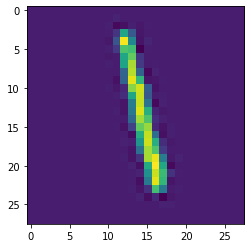

In [15]:
plt.imshow(one_img.squeeze())

In [16]:
imgs = jnp.array([rotate(one_img, 5.5 * i, reshape=False) for i in range(12)])

In [17]:
pred = model.apply(params, imgs, deterministic=False, rngs={"dropout": jax.random.PRNGKey(0)})
jnp.argmax(pred, axis=1)

DeviceArray([1, 1, 1, 1, 1, 1, 1, 7, 7, 7, 7, 7], dtype=int64)

# MC Dropout

In [18]:
n_stacks = 100
y_stacks = []
fn = lambda i: model.apply(params, imgs, deterministic=False, rngs={"dropout": jax.random.PRNGKey(i)})
y_stacks = jax.vmap(jax.jit(fn), in_axes=(0))(jnp.arange(n_stacks))

In [19]:
logits_stacks = y_stacks[:, :, (1, 3, 7)]

In [20]:
# logits_mean = logits_stacks.mean(axis=0)
# logits_std = logits_stacks.std(axis=0)

In [21]:
soft_stacks = nn.softmax(logits_stacks, axis=-1)

In [22]:
# soft_mean = soft_stacks.mean(axis=0)
# soft_std = soft_stacks.std(axis=0)

In [23]:
def offset_image(coord, i, ax, low_img, low_index, zoom):
    img = imgs[i]
    im = OffsetImage(img.squeeze(), zoom=zoom)
    im.image.axes = ax

    ab = AnnotationBbox(
        im,
        (coord, low_img),
        xybox=(0.0, low_index),
        frameon=False,
        boxcoords="offset points",
    )
    ax.add_artist(ab)

/home/rohit_khoiwal/anaconda3/lib/python3.9/site-packages/probml_utils/plotting.py:80: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


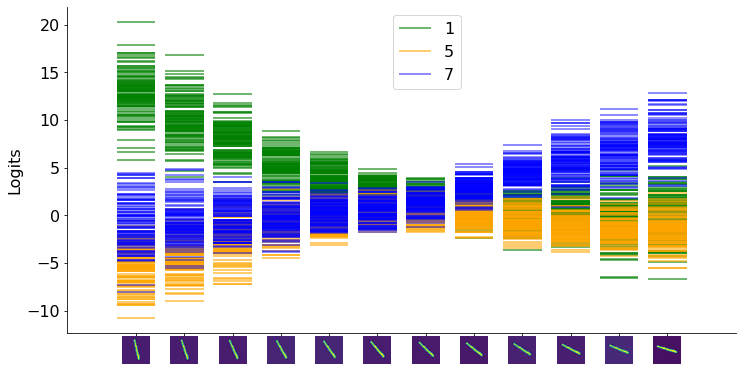

In [24]:
if is_latexify_enabled():
    fig, ax = plt.subplots(1)
    zoom = 0.4
else:
    plt.rcParams["font.size"] = 16
    fig, ax = plt.subplots(1, figsize=(12, 6))
    zoom = 1
index = jnp.arange(12)
for i in range(12):
    ax.eventplot(
        logits_stacks[:, i, 0],
        orientation="vertical",
        lineoffsets=i,
        linelengths=0.8,
        colors="green",
        alpha=0.75,
    )
    ax.eventplot(
        logits_stacks[:, i, 1],
        orientation="vertical",
        lineoffsets=i,
        linelengths=0.8,
        colors="orange",
        alpha=0.75,
    )
    ax.eventplot(
        logits_stacks[:, i, 2],
        orientation="vertical",
        lineoffsets=i,
        linelengths=0.8,
        colors="blue",
        alpha=0.6,
    )

ax.set_xticks(index)
ax.set_xticklabels(index + 1)
ax.tick_params(axis="x", which="major", pad=8)
ax.set_ylabel("Logits")
l, h = ax.get_ylim()
for i in index:
    offset_image(i, i, ax, l, l - 5, zoom)
ax.legend(["1", "5", "7"], bbox_to_anchor=(0.6, 1.0))
sns.despine()
savefig("mnist_softmax_input", tight_bbox=True, pad=1)
plt.show()

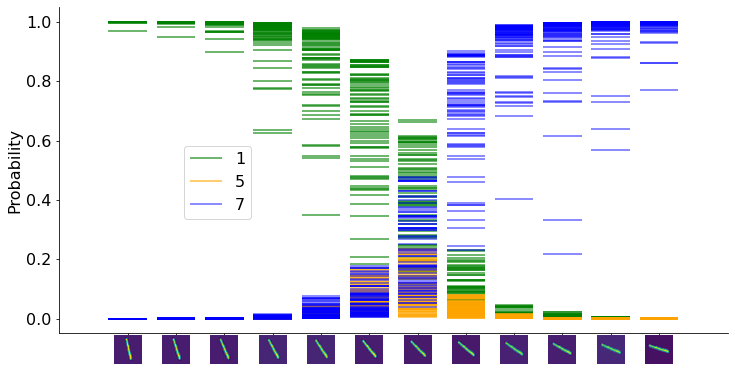

In [25]:
if is_latexify_enabled():
    fig, ax = plt.subplots(1)
    zoom = 0.4
else:
    plt.rcParams["font.size"] = 16
    fig, ax = plt.subplots(1, figsize=(12, 6))
    zoom = 1
for i in range(12):
    ax.eventplot(
        soft_stacks[:, i, 0].sort()[:75],
        orientation="vertical",
        lineoffsets=i,
        linelengths=0.8,
        colors="green",
        alpha=0.75,
    )
    ax.eventplot(
        soft_stacks[:, i, 1].sort()[:75],
        orientation="vertical",
        lineoffsets=i,
        linelengths=0.8,
        colors="orange",
        alpha=0.75,
    )
    ax.eventplot(
        soft_stacks[:, i, 2].sort()[:75],
        orientation="vertical",
        lineoffsets=i,
        linelengths=0.8,
        colors="blue",
        alpha=0.6,
    )

ax.set_xticks(index)
ax.set_xticklabels(index + 1)
ax.tick_params(axis="x", which="major", pad=8)
ax.set_ylabel("Probability")
l, h = ax.get_ylim()
for i in index:
    offset_image(i, i, ax, l, l - 17, zoom)

ax.legend(["1", "5", "7"], loc="best", bbox_to_anchor=(0.3, 0.6))
sns.despine()
savefig("mnist_softmax_output_", tight_bbox=True, pad=1)
plt.show()